# Bayesian Machine Learning : Naive Bayes Classifier

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## The Iris dataset

We will work with the Ronald Fischer dataset, which dates from 1936 and contains data on irises.

We will see that the first 4 columns correspond respectively to the length of the sepal, the width of the sepal
the length of the petal and the width of the petal (all these measurements are in centimetres). These 4 variables will constitute the input. The fifth column corresponds to the species of the iris (which can be: Iris-Setosa, Iris-Versicolor or Iris-Virginica) and constitutes the output. It is therefore a classification problem: we want to build a predictor predicting the species according to the other characteristics.

### Question 1: Prepare the dataset

- Import the [Iris dataset](https://curiousml.github.io/teaching/epita-python/Iris.csv)
- Rename the column `Species` by `y`
- Replace the Species 
    - `Iris-setosa` by $0$, 
    - `Iris-versicolor` by $1$ and 
    - `Iris-virginica` by $2$
- Shuffle the dataset

In [3]:
import pandas as pd
import numpy as np

# Load the Iris dataset from the uploaded file
file_path = 'C:/Users/sanja/OneDrive/Desktop/AIS S3/Bayesian and unsupervised methods/Iris.csv'
df = pd.read_csv(file_path)

# Rename the column 'Species' to 'y'
df.rename(columns={'Species': 'y'}, inplace=True)

# Replace species names with numeric values
df['y'] = df['y'].replace({
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
})

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows of the prepared dataset
print(df.head())


    Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  y
0   74            6.1           2.8            4.7           1.2  1
1   19            5.7           3.8            1.7           0.3  0
2  119            7.7           2.6            6.9           2.3  2
3   79            6.0           2.9            4.5           1.5  1
4   77            6.8           2.8            4.8           1.4  1


C:\Users\sanja\AppData\Local\Temp\ipykernel_21196\3180521579.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({


First, we want to simplify the dataset by reducing the dimension of the input space from 4 to 2. We then need to determine which two variables seem to be the most promising for predicting the species. To do this, we will use the sns.pairplot function from the Seaborn library.

```
import seaborn as sns
sns.pairplot(iris, hue="y")
```

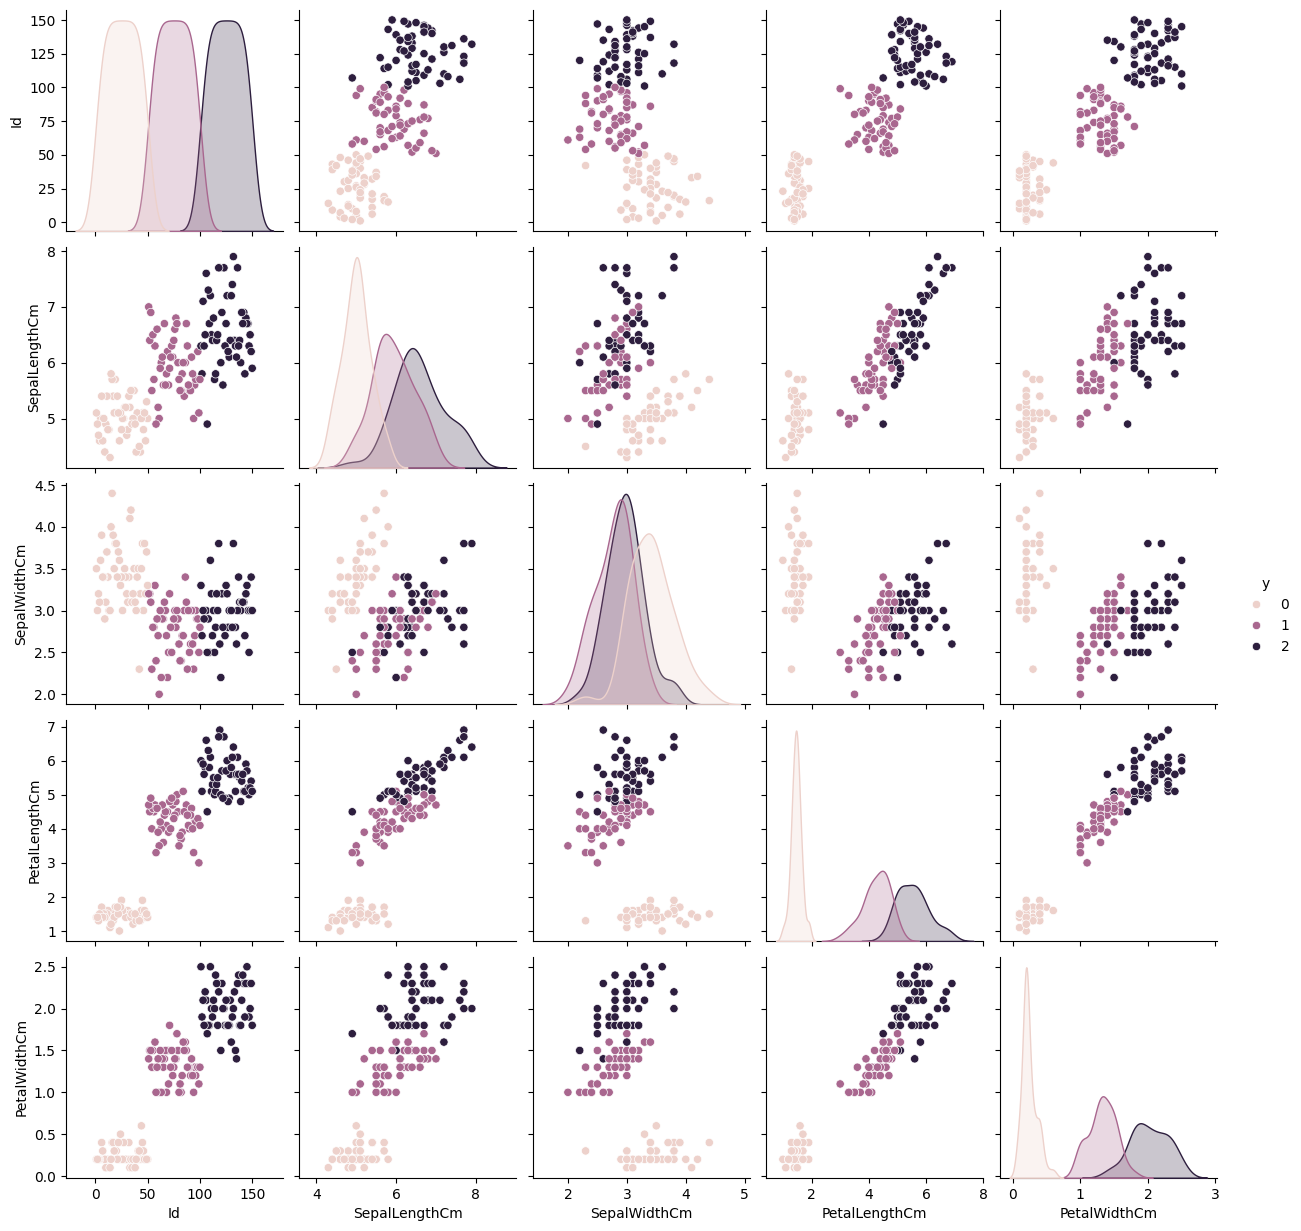

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pairplot
sns.pairplot(df, hue="y")
plt.show()

### Question 2: simplify the dataset

Create an array `X` containing the columns corresponding to the two selected variables, as well as an array `y` containing the column corresponding to the species (`iris.values` can be used to return all the data from the iris DataFrame iris in the form of an NumPy array).

In [5]:
# Drop the 'Id' column
df.drop(columns='Id', inplace=True)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

#selecting two features
X = df[['PetalLengthCm', 'PetalWidthCm']].values

# Select the target variable
y = df['y'].values

# Display the first few rows of X and y
print("X:\n", X[:5])
print("y:\n", y[:5])

X:
 [[5.1 1.9]
 [4.5 1.3]
 [3.5 1. ]
 [1.7 0.4]
 [5.4 2.3]]
y:
 [2 1 1 0 2]


### Question 3: split the dataset

Split the dataset into two samples: a training sample of size 90 (called `X_train` and `y_train`), and a test sample of size 60 (called `X_test` and `y_test`).

In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=90, test_size=60, random_state=42)

# Display the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (90, 2)
y_train shape: (90,)
X_test shape: (60, 2)
y_test shape: (60,)


## Naive Bayes Classifier (from scratch)

Let us fit a [Naive Bayes Classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier), more particularily a **Gaussian Naive Bayes Classifier** where $P(X_i|Y)$ is a Gaussian probability distribution.

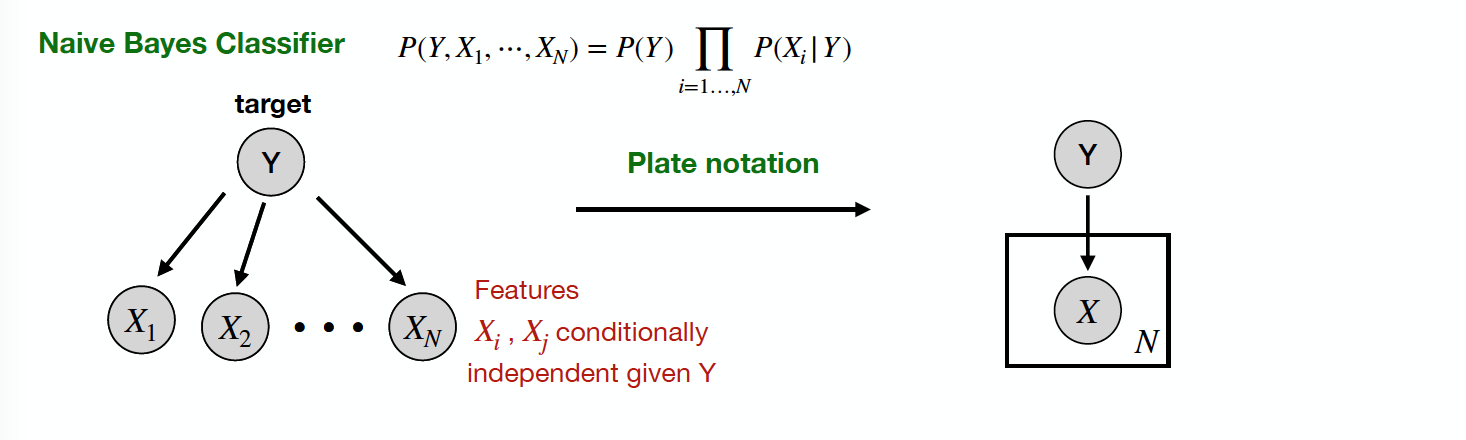

We are interested in the conditional probability of each input variable. This means we need:
1. one distribution for each of the input variables, and 
2. one set of distributions for each of the class labels.

As a first step let us model the input variables using a Gaussian probability distribution.

### Question 4: fit a gaussian probability distribution

Let us fit a Gaussian probability distribution to each feature. Create a function `fit_gaussian(feature)` which takes one input feature and fits a Gaussian probability distribution.

**Rmk:**
- you can use the `norm` function of `scipy.stats` for constructing a distribution;
- you can use the `mean` and the `std` function of `numpy` for estimating the parameters of the distribution

In [8]:
from scipy.stats import norm

def fit_gaussian(feature):
    """
    Fit a Gaussian probability distribution to a given feature.
    
    Parameters:
    feature (array-like): The input feature data.
    
    Returns:
    dist (scipy.stats._distn_infrastructure.rv_frozen): The fitted Gaussian distribution.
    mean (float): The mean of the feature.
    std (float): The standard deviation of the feature.
    """
    mean = np.mean(feature)
    std = np.std(feature)
    dist = norm(loc=mean, scale=std)
    
    return dist, mean, std

### Question 5: split the training set

Split the training set into groups of samples for each of the class labels $0, 1, 2$. Name them respectively `X_train0`, `X_train1` and `X_train2`. These groups are used to calculate the prior probabilities $P(Y)$ for a data sample belonging to each group.

In [10]:
# Splitting the training set into groups based on class labels
X_train0 = X_train[y_train == 0]
X_train1 = X_train[y_train == 1]
X_train2 = X_train[y_train == 2]

### Question 6: generate the priors $P(Y=y)$

Use `X_train0`, `X_train1` and `X_train2` to calculate the prior probabilities $P(Y=y)$ for $y\in\{0, 1, 2\}$. Name them respectively `prior0`, `prior1` and `prior2`

In [11]:
# Calculate the prior probabilities
prior0 = len(X_train0) / len(X_train)
prior1 = len(X_train1) / len(X_train)
prior2 = len(X_train2) / len(X_train)

print("Prior probabilities:")
print("P(Y=0):", prior0)
print("P(Y=1):", prior1)
print("P(Y=2):", prior2)


Prior probabilities:
P(Y=0): 0.3
P(Y=1): 0.37777777777777777
P(Y=2): 0.32222222222222224


Finally, we can call the `fit_gaussian` function that we defined to prepare a probability distribution for each variable, for each class label.

### Question 7: generate the PDFs $P(X_i|Y=y)$ 

Generate the PDFs $P(X_i|Y=y)$ for $y\in\{0, 1, 2\}$.

In [13]:
pdfs = {}

# Iterate over each variable
for i in range(X_train.shape[1]):
    pdfs[i] = {}
    
# For each class label
    for y in [0, 1, 2]:
        # Fit Gaussian distribution for the variable for the current class
        dist, mean, std = fit_gaussian(X_train[y_train == y][:, i])
        pdfs[i][y] = (dist, mean, std)

# Example usage
pdf_variable_0_class_1 = pdfs[0][1]
print("PDF for variable 0, class label 1:", pdf_variable_0_class_1)


PDF for variable 0, class label 1: (<scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000029CA0B1E760>, 4.294117647058823, 0.4385411486968424)


### Question 8: generate the joint probabilities $P(Y=y, X_1, X_2)$


Create a function `joint_proba(X, prior, distX1, distX2)` which computes $P(Y, X_1, X_2)$ for a given class $Y=y$ (example $y=0$).
- `prior` corresponds to the prior probability $P(Y=y)$
- and `distXi`, $i=1, 2$, corresponds to $P(X_i|Y=y)$.

In [17]:
def joint_proba(X, prior, distX1, distX2):
    """
    Compute the joint probability P(Y, X1, X2) for a given class Y=y.

    Parameters:
    X (array-like): Input feature data for X1 and X2.
    prior (float): Prior probability P(Y=y).
    distX1 (object): Gaussian distribution object for X1 given Y=y.
    distX2 (object): Gaussian distribution object for X2 given Y=y.

    Returns:
    joint_proba (array-like): Joint probability P(Y, X1, X2) for the given class Y=y.
    """
    # Calculate the likelihood P(X1|Y=y) and P(X2|Y=y) using Gaussian distribution
    likelihood_X1 = distX1.pdf(X[:, 0])
    likelihood_X2 = distX2.pdf(X[:, 1])
    
    # Compute the joint probability
    joint_proba = prior * likelihood_X1 * likelihood_X2
    
    return joint_proba



### Question 9: performance on the test set

- Compute the probabilities $P(Y=y, X_1, X_2)$ for $y\in\{0, 1, 2\}$.
- Evaluate the `Accuracy` of the model on the test set `X_test`

In [20]:
def predict(X, priors, dists):
    """
    Predict the class labels for the given data points X.

    Parameters:
    X (array-like): Input feature data.
    priors (dict): Dictionary containing prior probabilities for each class.
    dists (dict): Dictionary containing Gaussian distribution parameters for each class.

    Returns:
    predictions (array-like): Predicted class labels.
    """
    predictions = []
    for x in X:
        # Compute the joint probabilities for each class
        joint_probs = [joint_proba(x.reshape(1, -1), priors[y], dists[0][y], dists[1][y]) for y in [0, 1, 2]]
        # Predict the class label with the highest joint probability
        predicted_class = np.argmax(joint_probs)
        predictions.append(predicted_class)
    return predictions

# Compute probabilities P(Y=y, X1, X2) for each class y
dists = {i: {y: pdfs[i][y][0] for y in [0, 1, 2]} for i in range(X_train.shape[1])}
priors = {y: len(X_train[y_train == y]) / len(X_train) for y in [0, 1, 2]}
predictions = predict(X_test, priors, dists)

# Evaluate accuracy
accuracy = np.mean(predictions == y_test) * 100
print("Accuracy on the test set:", accuracy, "%")


Accuracy on the test set: 98.33333333333333 %


## Naive Bayes Classifier (with external package)

### Question 10: GaussianNB of sklearn

- Create and train a Gaussian Classifier using `GaussianNB` of the external submodule `sklearn.naive_bayes`.
```
from sklearn.naive_bayes import GaussianNB
```


- Evaluate the `Accuracy` of the model on the test set `X_test`.

**Rm:** You should have (approximately) the same accuracy as in **Question 9**.

In [21]:
from sklearn.naive_bayes import GaussianNB

# Create Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the classifier on the training data
gnb.fit(X_train, y_train)

# Evaluate accuracy on the test set
accuracy = gnb.score(X_test, y_test) * 100
print("Accuracy on the test set:", accuracy, "%")


Accuracy on the test set: 98.33333333333333 %


## Some advantages

- Fast and accurate method for prediction.


- Naive Bayes has very low computation cost.


- It can efficiently work on a large dataset.


- It can be used in multi-class tasks.


- When the assumption of independence holds, a Naive Bayes classifier performs better compared to other models like logistic regression.

## Disadvantages

- The assumption of independent features. 